In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# **NLP Disaster Tweet Prediction Kaggle Deep Learning Mini Project**

This project focuses on leveraging Natural Language Processing (NLP) and Recurrent Neural Networks (RNNs) to classify tweets as disaster-related or not. The dataset, provided by Kaggle's "Getting Started with NLP" competition, includes a variety of tweets labeled as either relevant or irrelevant to disasters. The objective is to develop a robust deep learning model capable of understanding the context and nuances in text to make accurate predictions.

### Motivation

In an age where social media platforms like Twitter serve as critical communication channels during disasters, accurate identification of disaster-related content can greatly enhance response efficiency. Automating this process through deep learning models allows for rapid filtering of important information, assisting emergency services, governments, and humanitarian organizations.

### Why Use RNNs?

Recurrent Neural Networks (RNNs) are particularly suited for sequential data like text due to their ability to process information in order and capture temporal dependencies. Special variants like Long Short-Term Memory (LSTM) networks and Bidirectional RNNs are ideal for this task as they address common challenges such as vanishing gradients and context preservation. LSTMs excel at understanding long-term dependencies, while Bidirectional RNNs process sequences in both directions, ensuring a comprehensive understanding of the text. By exploring techniques such as attention mechanisms and integrating additional features like sentiment analysis, the project delves deeper into training and optimizing RNN architectures for this classification task.

### Citation

This project uses the dataset and guidelines provided by Kaggle in the competition "NLP Getting Started." For more details, visit the competition page: 

[Kaggle NLP Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/overview).

# **Step 1: Data Exploration and Preprocessing**
We need to explore the dataset and clean the text data for feeding into the RNN model. This will include: 
-  Importing the dataset
-  Viewing a smaple of tweet text
-  Preprocessing and cleaning the text (Lowercase, Remove links, remove special characters and numebrs, remove extra spaces
-  Tokenizing the text + padding sequences (vector representation)
-  Apply methods to both training and testing data (consistency in evaluation)

In [13]:
import pandas as pd
import numpy as np
import re
import os

# Load the datasets
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

# Check data structure
print(train_data.head())
print(train_data.info())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


In [14]:
# Tokenize and Pad Sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Function to clean the text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters and numbers
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

# Apply cleaning
train_data['cleaned_text'] = train_data['text'].apply(clean_text)
test_data['cleaned_text'] = test_data['text'].apply(clean_text)


max_words = 10000  # Maximum number of unique words (entire dataset)
max_len = 50       # Maximum length 

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['cleaned_text'])

# Convert text to sequences
X_train = tokenizer.texts_to_sequences(train_data['cleaned_text'])
X_test = tokenizer.texts_to_sequences(test_data['cleaned_text'])

# Pad sequences to ensure equal length
X_train = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')

# Extract target
y_train = train_data['target'].values

### Exploratory Data Analysis 
- Take an inside look at the training data by visualizing:
  
1. Most common words (not including stop words)
2. Tweet Length Distribution (How much of the text allottment do they use? (Out of max 144 characters)
3. Popular hashtags


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


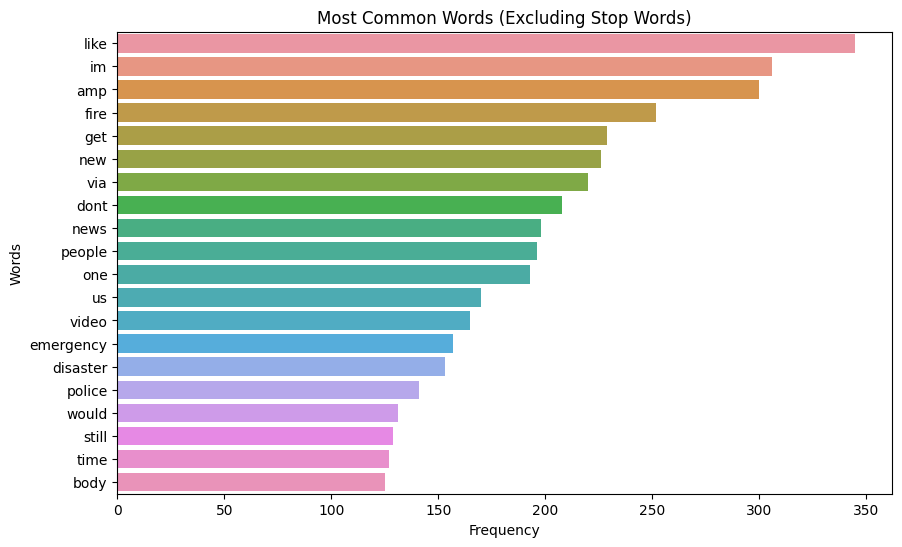

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


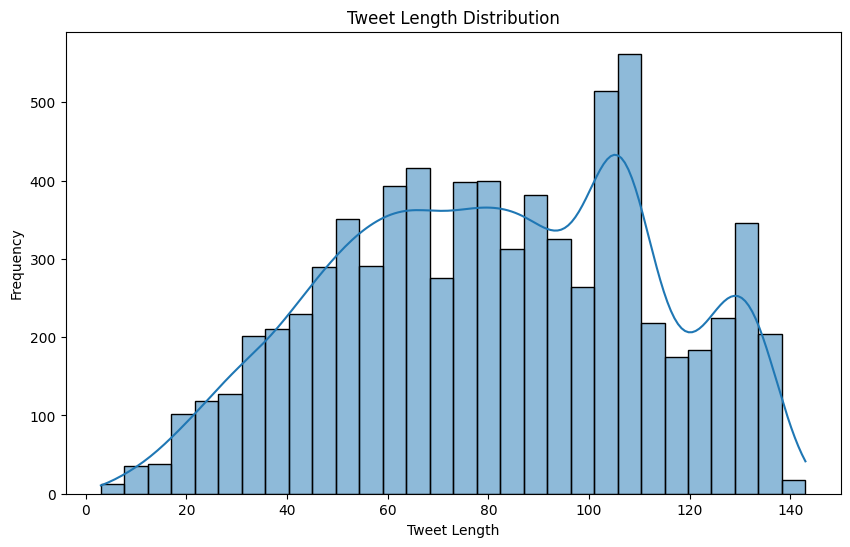

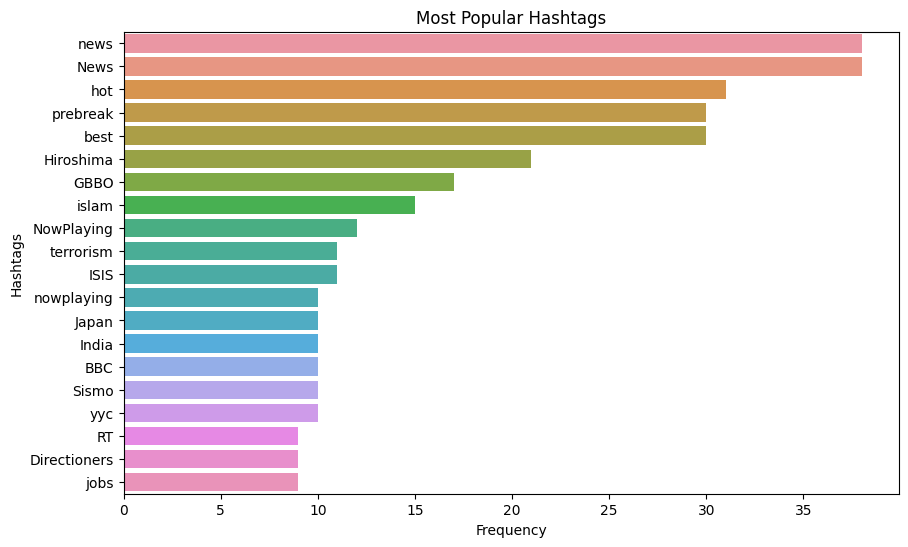

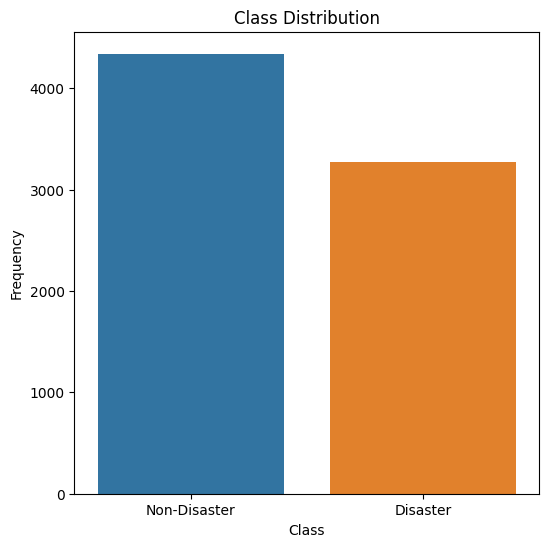

In [15]:
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Define stop words
stop_words = set(stopwords.words('english'))

# 1. Most Common Words
def get_most_common_words(texts, num_words=20):
    # Tokenize and filter stop words
    all_words = []
    for text in texts:
        tokens = word_tokenize(text)
        filtered_words = [word for word in tokens if word not in stop_words]
        all_words.extend(filtered_words)
    word_counts = Counter(all_words)
    return word_counts.most_common(num_words)

common_words = get_most_common_words(train_data['cleaned_text'], num_words=20)
words, counts = zip(*common_words)

# Convert to DataFrame for plotting
common_words_df = pd.DataFrame({'Words': words, 'Counts': counts})

# Plot Most Common Words
plt.figure(figsize=(10, 6))
sns.barplot(data=common_words_df, x='Counts', y='Words')
plt.title('Most Common Words (Excluding Stop Words)')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

# 2. Tweet Length Distribution
train_data['tweet_length'] = train_data['cleaned_text'].apply(len)

# Plot Tweet Length Distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_data['tweet_length'], bins=30, kde=True)
plt.title('Tweet Length Distribution')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

# 3. Popular Hashtags
def extract_hashtags(text):
    return re.findall(r"#(\w+)", text)

train_data['hashtags'] = train_data['text'].apply(extract_hashtags)
all_hashtags = sum(train_data['hashtags'], [])  # Flatten list of lists
hashtag_counts = Counter(all_hashtags)

# Top 20 Hashtags
top_hashtags = hashtag_counts.most_common(20)
hashtags, hashtag_freqs = zip(*top_hashtags)

# Convert to DataFrame for plotting
hashtags_df = pd.DataFrame({'Hashtags': hashtags, 'Frequency': hashtag_freqs})

# Plot Popular Hashtags
plt.figure(figsize=(10, 6))
sns.barplot(data=hashtags_df, x='Frequency', y='Hashtags')
plt.title('Most Popular Hashtags')
plt.xlabel('Frequency')
plt.ylabel('Hashtags')
plt.show()

# 4. Class Distribution (Disaster vs Non-Disaster)
plt.figure(figsize=(6, 6))
sns.countplot(x=train_data['target'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Non-Disaster', 'Disaster'])
plt.show()

 ### After EDA:

- **Most Common Words (Excluding Stop Words)**: The most frequent words in the dataset, excluding stop words, indicating common themes and conversational tones in the tweets.
- **Tweet Length Distribution**: The distribution of tweet lengths shows a peak around 100-120 characters, indicating most tweets are concise and near the length limit (limit of 144).

- **Most Popular Hashtags**: The most frequently used hashtags include #news, #hot, and #prebreak, reflecting trending topics in the dataset.
- **Class Distribution**: The dataset is slightly imbalanced, with more non-disaster tweets compared to disaster tweets.

# **Step 2: Build the RNN Model**
We’ll use an LSTM-based architecture for text classification.

### 2.1 Define the Model

This Sequential model is a binary classification RNN built for processing tweet data It consists of:

- **Embedding Layer**: Converts input words into dense 100-dimensional vectors to capture semantic meaning.
- **LSTM Layer**: Uses 128 units to capture sequential dependencies in the text.
- **Dropout Layers**: Prevents overfitting by randomly deactivating 20% of neurons during training.
- **Dense Layers**: A 64-unit hidden layer with ReLU activation and a final output layer with a sigmoid activation for binary classification (e.g., disaster vs. non-disaster).  
- **Compilation**: Uses the Adam optimizer and binary cross-entropy loss to optimize accuracy for a binary classification task.

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define the RNN Model
embedding_dim = 100

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    LSTM(128, return_sequences=False),  # LSTM Layer
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model.build(input_shape=(None, max_len))  # Specify input shape for building the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,125,569 (4.29 MB)

 Trainable params: 1,125,569 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

# **Step 3: Train the Model**
### 3.1 Training the Model

In [17]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Check shapes
print(f"Training data shape: {X_train_split.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (6090, 50)
Validation data shape: (1523, 50)


In [18]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_split,
    y_train_split,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5693 - loss: 0.6846 - val_accuracy: 0.5739 - val_loss: 0.6867
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5660 - loss: 0.6869 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5797 - loss: 0.6815 - val_accuracy: 0.5739 - val_loss: 0.6827
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5735 - loss: 0.6835 - val_accuracy: 0.5739 - val_loss: 0.6825
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5589 - loss: 0.6867 - val_accuracy: 0.5739 - val_loss: 0.6832


In [19]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Validation Loss: {val_loss:.2f}")

Validation Accuracy: 0.57
Validation Loss: 0.68


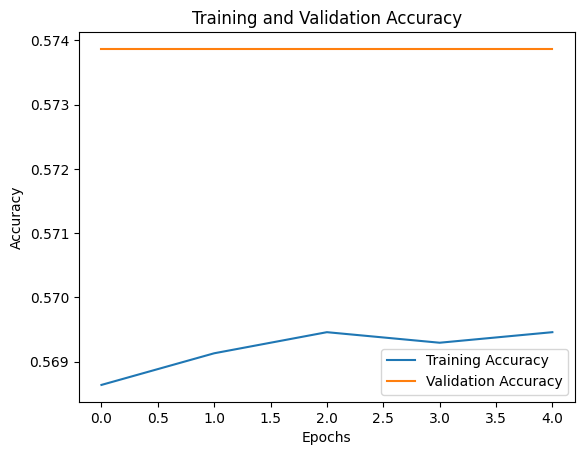

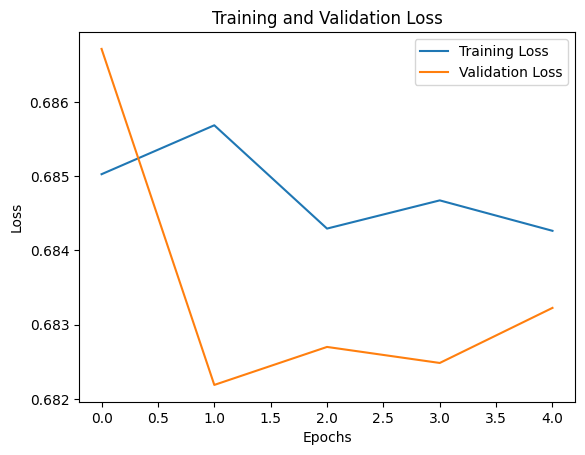

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


# Step 4. Building a different Model. 

### Adjusted the above model with a variety of tweaks:

- **Increase LSTM from 128 to 256**: Increasing the number of LSTM units allows the model to capture more complex patterns and dependencies in the sequential data, potentially improving its capacity to learn from longer or more nuanced text sequences (This did improve the model, so we kept it for all remaining tweaks).

- **Add Bidirectional Component to the LSTM 256**: A Bidirectional LSTM processes text in both forward and backward directions, allowing the model to learn context from both past and future words, which can significantly improve its understanding of sequential dependencies in the text (Again, this tweak was kept in for the remaining tweaks as well, as it increased training accuracy from around 50% to around 80%).

- **Noticed Overfitting the training data; increase dropout rates, or use L2 regularization, or adjust learning rate**: Plotting the loss and accuracy suggested the model was overfitting the training data. This assumes  the model is memorizing training data instead of generalizing. Increasing dropout rates, using L2 regularization (which penalizes large weights), or adjusting the learning rate (to avoid aggressive updates) are common strategies to reduce overfitting and improve model generalization. The next tweak was increasing/ messing around with dropout rates.

- **Increasing dropout rates did not help**: If higher dropout rates fail to resolve overfitting, it suggests that overfitting might be due to other factors, such as insufficient regularization (e.g., L2) or an excessively large model capacity relative to the dataset size, requiring other strategies like reducing model size or enhancing data augmentation.

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# Define the RNN Model with Bidirectional LSTM
embedding_dim = 100

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(256, return_sequences=False)),  # Bidirectional LSTM Layer
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model.build(input_shape=(None, max_len))  # Specify input shape for building the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 512)            │       731,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,764,033 (6.73 MB)

 Trainable params: 1,764,033 (6.73 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_split,
    y_train_split,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Validation Loss: {val_loss:.2f}")

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6621 - loss: 0.5990 - val_accuracy: 0.7971 - val_loss: 0.4458
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8784 - loss: 0.3211 - val_accuracy: 0.7965 - val_loss: 0.4990
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9117 - loss: 0.2292 - val_accuracy: 0.7853 - val_loss: 0.5970
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9489 - loss: 0.1398 - val_accuracy: 0.7886 - val_loss: 0.6408
Validation Accuracy: 0.80
Validation Loss: 0.45


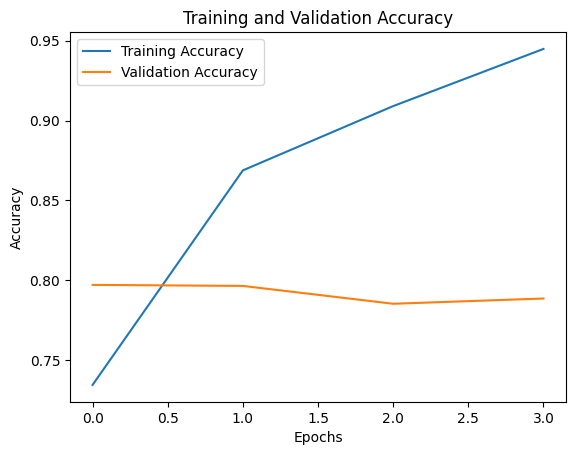

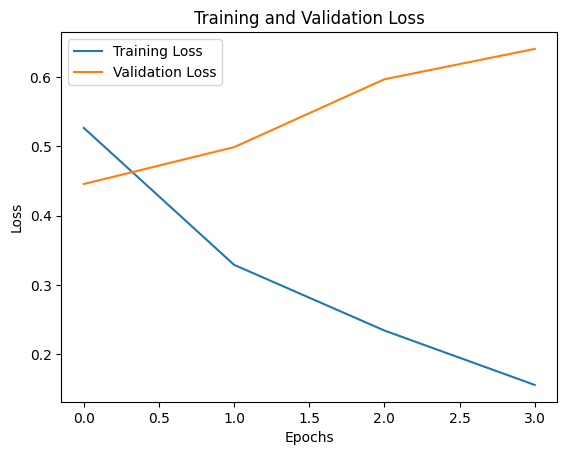

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [25]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(256, return_sequences=False)),  # Bidirectional LSTM Layer
    Dropout(0.4),  # Increased dropout to 40%
    Dense(64, activation='relu'),
    Dropout(0.4),  # Increased dropout to 40%
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model.build(input_shape=(None, max_len))  # Specify input shape for building the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(
    X_train_split,
    y_train_split,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 50, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 512)            │       731,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,764,033 (6.73 MB)

 Trainable params: 1,764,033 (6.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6532 - loss: 0.6169 - val_accuracy: 0.8004 - val_loss: 0.4402
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8664 - loss: 0.3386 - val_accuracy: 0.7827 - val_loss: 0.4748
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9113 - loss: 0.2370 - val_accuracy: 0.7827 - val_loss: 0.5848
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9473 - loss: 0.1497 - val_accuracy: 0.7617 - val_loss: 0.6230


In [26]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the learning rate scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.5,          # Reduce the learning rate by a factor of 0.5
    patience=2,          # Wait 2 epochs without improvement
    verbose=1,           # Print learning rate updates
    min_lr=1e-6          # Set a lower bound for the learning rate
)

# Retrain the model with the new callback
history = model.fit(
    X_train_split,
    y_train_split,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]  # Include ReduceLROnPlateau
)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8548 - loss: 0.3508 - val_accuracy: 0.7741 - val_loss: 0.4777 - learning_rate: 0.0010
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9012 - loss: 0.2469 - val_accuracy: 0.7708 - val_loss: 0.5581 - learning_rate: 0.0010
Epoch 3/10
187/191 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9389 - loss: 0.1611
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9389 - loss: 0.1612 - val_accuracy: 0.7610 - val_loss: 0.6148 - learning_rate: 0.0010


# Model used for submisison:
### Key Characteristics

- **Embedding Layer**: Converts input text into 100-dimensional dense word embeddings, capturing semantic meaning for downstream processing.

- **Bidirectional LSTM**: Utilizes a Bidirectional LSTM with 128 units to process the sequence both forward and backward, enabling the model to learn context from both past and future words.

- **Custom Attention Layer**: Implements a custom Attention mechanism to focus on the most relevant parts of the input sequence, enhancing interpretability and improving performance by prioritizing key information.

- **Dropout Layers**: Includes 30% dropout after the Attention layer and the Dense layer to mitigate overfitting and ensure better generalization.

- **Dense Layers**: A 64-unit hidden Dense layer with ReLU activation extracts higher-level features, followed by a final Dense layer with sigmoid activation for binary classification.

- **Model Optimization**: Compiled with the Adam optimizer and binary cross-entropy loss to effectively handle the binary classification problem and ensure efficient convergence.

- **Early Stopping Callback**: Utilized `early_stop` to terminate training when validation performance stops improving, preventing overfitting and saving computational resources.

In [28]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Layer
import tensorflow as tf

# Define an Attention Layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="attention_weight",
            shape=(input_shape[-1], 1),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name="attention_bias",
            shape=(input_shape[1], 1),
            initializer="zeros",
            trainable=True,
        )
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.nn.tanh(tf.matmul(x, self.W) + self.b)
        alpha = tf.nn.softmax(e, axis=1)
        context = tf.reduce_sum(alpha * x, axis=1)
        return context

# Define the RNN Model with Attention
embedding_dim = 100

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=True)),  # Enable return_sequences for Attention
    Attention(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Output layer
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_1 (Attention)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
history = model.fit(
    X_train_split,
    y_train_split,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5917 - loss: 0.6598 - val_accuracy: 0.7938 - val_loss: 0.4584
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8132 - loss: 0.4394 - val_accuracy: 0.8089 - val_loss: 0.4529
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8921 - loss: 0.2864 - val_accuracy: 0.7511 - val_loss: 0.5544


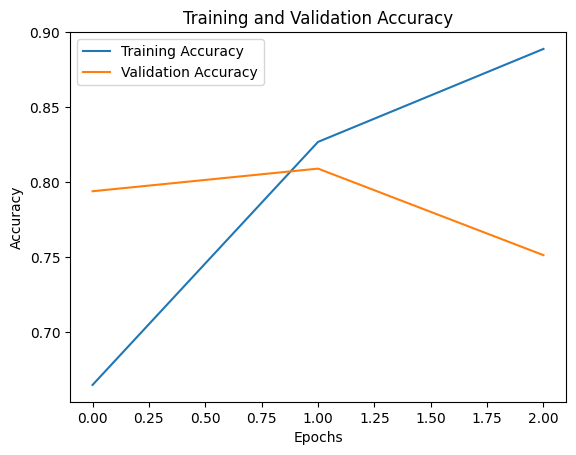

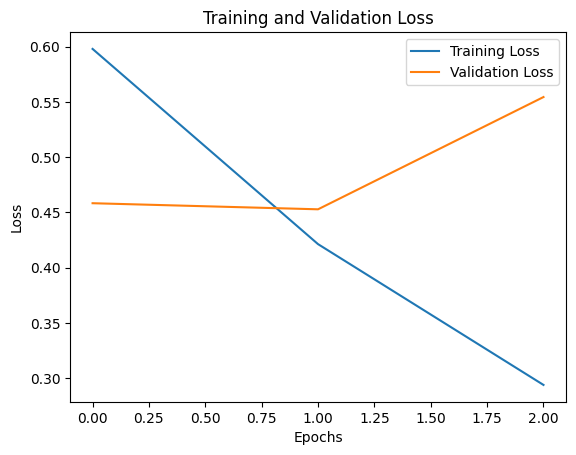

In [30]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### Submission Code

In [31]:
predictions = model.predict(X_test)
predictions_binary = (predictions > 0.5).astype(int).flatten()

submission = pd.DataFrame({'id': test_data['id'], 'target': predictions_binary})
submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


---
# **Model 1 Submission Score:**
# **0.72172**
---

# Second Model for Submssion: 

### Changes from Previous model (Model 1 and this Model)

- **Added Sentiment Input**: Introduced an additional input layer for external sentiment features (polarity and subjectivity), integrating sentiment analysis directly into the model's decision-making.

- **Concatenation Layer**: Combined the output of the LSTM (from the text input) with the sentiment features, enabling the model to leverage both sequential and sentiment-based information for classification.

- **Removed Attention Layer**: The custom Attention mechanism from the previous model was replaced, relying on the concatenated sentiment features to provide additional context instead.

- **Flattening Removed**: Since `return_sequences=False` was set in the LSTM layer, no flattening operation was needed, reducing computational complexity.

- **Model Architecture Change**: Switched from the `Sequential` API to the `Functional` API, providing flexibility for handling multiple inputs and concatenations.

These changes aim to enrich the model's ability to make predictions by incorporating external sentiment-based features alongside the text processing pipeline.

### First, Add Sentiment Analysis to the text and score

In [35]:
from textblob import TextBlob

# Function to extract sentiment features (polarity and subjectivity)
def extract_sentiment(text):
    blob = TextBlob(text)
    return blob.polarity, blob.subjectivity

# Apply sentiment analysis to the training and test datasets
train_data['polarity'], train_data['subjectivity'] = zip(*train_data['text'].apply(extract_sentiment))
test_data['polarity'], test_data['subjectivity'] = zip(*test_data['text'].apply(extract_sentiment))

# Prepare sentiment features for the model
train_sentiment = train_data[['polarity', 'subjectivity']].values
test_sentiment = test_data[['polarity', 'subjectivity']].values

# Confirm shapes of input arrays
print("Train sentiment shape:", train_sentiment.shape)
print("Test sentiment shape:", test_sentiment.shape)

Train sentiment shape: (7613, 2)
Test sentiment shape: (3263, 2)


In [36]:
from tensorflow.keras.layers import Concatenate, Input, Flatten
from tensorflow.keras.models import Model

# Define inputs
text_input = Input(shape=(max_len,))
sentiment_input = Input(shape=(2,))  # For polarity and subjectivity

# Embedding and LSTM layers for text input
x = Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len)(text_input)
x = Bidirectional(LSTM(128, return_sequences=False))(x)

# Concatenate sentiment features with LSTM output
x = Concatenate()([x, sentiment_input])
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=[text_input, sentiment_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 50, 100)   │  1,000,000 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 256)       │    234,496 │ embedding_6[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 258)       │          0 │ bidirectional_5[… │
│ (Concatenate)       │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │     16,576 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │         65 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,251,137 (4.77 MB)

 Trainable params: 1,251,137 (4.77 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Predict on test data (text + sentiment features)
predictions = model.predict([X_test, test_sentiment])

# Convert probabilities to binary predictions
predictions_binary = (predictions > 0.5).astype(int).flatten()

# Create submission dataframe
submission = pd.DataFrame({
    'id': test_data['id'],  # Use the 'id' column from the test dataset
    'target': predictions_binary  # Predicted target values
})

# Save the submission file
submission.to_csv('submission.csv', index=False)
print("Submission file created successfully!")

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Submission file created successfully!


---
# **Model 2 Submission Score:**
# **0.56052**
---

### Discussion and Conclusions:

The performance drop from 0.72172 in the first model to 0.56052 in the second model highlights the challenges of incorporating additional features like sentiment analysis without careful integration and evaluation. While sentiment features (polarity and subjectivity) were included in the second model, their limited relevance or poor alignment with the text features likely hindered the model's ability to generalize effectively. 

#### Lessons from Prior Model Tuning:
1. **Model Capacity Adjustments**:
   - In earlier steps, increasing the LSTM units from 128 to 256 was explored to capture more complex patterns, but it risked overfitting due to the model's larger capacity. This suggests the importance of balancing model size with the dataset's complexity.

2. **Bidirectional LSTM**:
   - Adding bidirectional LSTM layers improved context understanding in earlier models, as processing text in both forward and backward directions provided a more comprehensive understanding of sequential dependencies.

3. **Overfitting Management**:
   - Efforts to reduce overfitting through dropout rates, L2 regularization, and learning rate adjustments revealed that merely increasing dropout rates was insufficient. These results suggest the need for more systematic experimentation with regularization techniques and early stopping criteria.

4. **Attention Mechanisms**:
   - The first model with a custom attention layer demonstrated the ability to focus on the most relevant parts of the text, which significantly contributed to its better performance. Its omission in the second model likely impacted the model's ability to differentiate between disaster and non-disaster tweets effectively.

5. **Sentiment Features**:
   - The introduction of sentiment analysis features was a novel attempt to integrate external knowledge, but the poor performance indicates that sentiment alone may not be highly predictive for this specific task. Additionally, the concatenation of these features might not have been well-aligned with the rest of the architecture, warranting further experimentation in feature fusion strategies.

#### Future Work:
1. **Improved Sentiment Integration**:
   - Explore more sophisticated sentiment models (e.g., transformer-based sentiment classifiers) or weighted feature fusion techniques to better combine sentiment and textual information.

2. **Pre-trained Models**:
   - Replace the embedding layer with pre-trained word embeddings (e.g., GloVe, FastText, or Word2Vec) or transformer-based embeddings (e.g., BERT or RoBERTa) to enhance the representation of text.

3. **Multi-Head Attention**:
   - Replace the custom attention layer with multi-head attention (as seen in transformer architectures) to provide the model with greater capacity to learn dependencies in text.

4. **Model Tuning**:
   - Conduct systematic hyperparameter tuning (e.g., grid search or Bayesian optimization) for LSTM units, dropout rates, learning rates, and batch sizes to ensure optimal performance.

5. **Data Augmentation and Balancing**:
   - Address the potential imbalance in disaster and non-disaster tweet labels by using data augmentation techniques such as paraphrasing, back-translation, or oversampling of underrepresented classes.

6. **Ensemble Approaches**:
   - Combine multiple models (e.g., text-only, attention-based, and sentiment-aware models) to leverage their respective strengths. Voting or weighted averaging could be employed for final predictions.

7. **Error Analysis**:
   - Conduct a thorough analysis of misclassified tweets to understand the model's failure points. This can guide additional feature engineering or architectural changes.

By combining insights from prior models and focusing on refining feature engineering, architecture design, and training strategies, future iterations can aim to better balance model complexity and generalization, ultimately achieving improved classification performance.